In [1]:
from sklearn.decomposition import PCA
from matplotlib import cm
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import torchvision
from torchvision import datasets, transforms

In [2]:
batch_size = 32
# numero di elementi che tengo in considerazione per lo step

train_dataset = datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))

test_dataset = datasets.MNIST('./data',
                                    train=False,
                               transform=transforms.Compose([
                       transforms.ToTensor(),
                   ]))



train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=batch_size,
                                               shuffle=False)

train_images = train_loader.dataset.data.detach().numpy().reshape(-1, 28*28)
print(f'Num training images: {len(train_images)},\tmin val: {train_images.min():.3f},\tmax val: {train_images.max():.3f}')

100%|██████████| 9912422/9912422 [00:00<00:00, 85783429.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 8909001.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33418659.83it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22625331.08it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Num training images: 60000,	min val: 0.000,	max val: 255.000


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dims,input_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dim**2, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dims,input_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, input_dim**2)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, input_dim, input_dim))

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims,input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims,input_dim)
        self.decoder = Decoder(latent_dims,input_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
def train(autoencoder, data, val_data, epochs=5):
    opt = torch.optim.Adam(autoencoder.parameters())
    losses = []
    val_losses = []

    for epoch in range(epochs):
        print("epoch: ",epoch)
        loss_e = 0
        loss_ve = 0

        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
        losses.append(loss_e/len(data))

        for x, y in val_data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
            loss_ve += loss.to('cpu').detach().numpy()
        val_losses.append(loss_ve/len(val_data))


    return autoencoder, losses, val_losses

In [8]:
latent_dims = 10
input_dim = 28
autoencoder = Autoencoder(latent_dims,input_dim).to(device) # GPU



In [9]:
autoencoder, losses , val_losses= train(autoencoder, train_loader, validation_loader,epochs=10)

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9


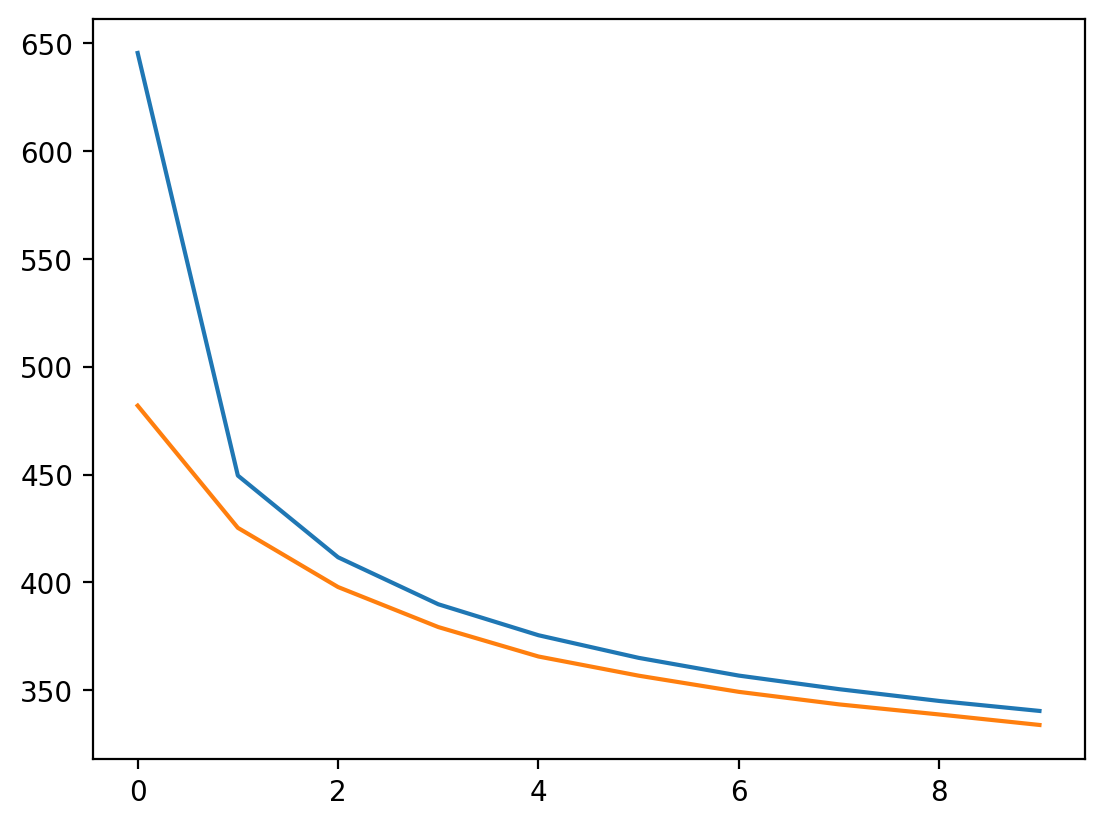

In [10]:
plt.plot(losses)
plt.plot(val_losses)
plt.show()